# BLU05 - Learning Notebook - Part 3 of 3 - Multi-step Forecasting

In [2]:
import utils 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [3]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    
    # return the aic 
    return results.aic

In [4]:
airlines = utils.load_airline_data()
airlines_logged = np.log(airlines)

## 1. Train-test Split

For multi-step prediction we're going to formulate the problem in a similar manner to a common ML problem. So the first thing to do is to separate the train and test, to make sure we don't leak any information. Sometimes simply looking at the test set can give us intuition that we shouldn't have. Remember that the objective of evaluating a model is to obtain a good estimation of the generalization error the model will have to never before seen data. For that, we need to pretend we don't know there is a test dataset, and use it only at the end as a good estimation of the generalization error.

Also, in timeseries dataset splits need to be done taking into account the temporal nature of the data. Basically, this means that in a simple train-test split we leave the first X months for training and the last Y months for testing.

In [5]:
train = airlines_logged[:-24]
test = airlines_logged[-24:]

## 2. Hyper Parameter Optimization

We're also going to need tunning for the multi-step forecasting problem, but it is going to be slightly different. Remember that for the one-step forecasting we used AIC because it accounted for overfitting. Well, the problem is that the AIC given by the SARIMAX fit refers to one-step predictions. An alternative for multi-step forecasting is going for a more ML oriented approach, using a validation set and another metric, such as the MAE.

In [6]:
p = d = q = P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 
S = [7, 12] # <-- let's pretend we have a couple of hypothesis 
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

_dejavu?_

For now just take this for granted, we're tunning the parameters using grid search. Basically, we find the parameters that give the best MAE for a validation set. This validation set should be the same lenght as the one we're going to before forecasting with the multi-step SARIMAX. In this case, 24 months.

In [7]:
def get_mae(series_, params, prediction_window):
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    lenght = len(series_)
    series_train = series_[:-prediction_window]
    series_test = series_[-prediction_window:]
    
    model = sm.tsa.statespace.SARIMAX(series_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, S),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

    results = model.fit(maxiter=500)
    prediction = results.get_forecast(steps=prediction_window)
    predicted_mean_logged = prediction.predicted_mean
    predicted_mean = predicted_mean_logged
    
    return mean_absolute_error(np.exp(series_test),np.exp(predicted_mean))

In [8]:
%%time 

prediction_window = 24
mae_scores = {}
params_index = {}

for i in range(len(inputs)):
        param_set = inputs[i]
        mae = get_mae(train, param_set, prediction_window) 
        mae_scores[i] = mae
        params_index[i] = param_set

CPU times: user 18.4 s, sys: 227 ms, total: 18.6 s
Wall time: 18.4 s


Wrangle these results into a usable dataframe 

_(note: don't worry if you don't understand this code too well for now)_

In [145]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['mae'] = pd.Series(mae_scores)
temp.sort_values('mae').head()

,p,d,q,P,D,Q,S,mae
79,1,0,0,1,1,1,12,11.025749
77,1,0,0,1,1,0,12,11.086999
29,0,0,1,1,1,0,12,11.785391
69,1,0,0,0,1,0,12,11.844362
71,1,0,0,0,1,1,12,12.387663


Great! What were the best params? 

In [122]:
best_model_params = temp.mae.idxmin()
temp.loc[best_model_params]

p       1.000000
d       0.000000
q       0.000000
P       1.000000
D       1.000000
Q       1.000000
S      12.000000
mae    11.025749
Name: 79, dtype: float64

Let's also see what we would get using the AIC on the train set

In [147]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(train, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

CPU times: user 21.3 s, sys: 25.8 ms, total: 21.4 s
Wall time: 21.4 s


In [149]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
75,1,0,0,1,0,1,12,-380.289735
91,1,0,1,1,0,1,12,-379.970084
107,1,1,0,1,0,1,12,-378.605436
59,0,1,1,1,0,1,12,-374.761183
123,1,1,1,1,0,1,12,-372.223858


In [150]:
best_model_params = temp.aic.idxmin()
temp.loc[best_model_params]

p        1.000000
d        0.000000
q        0.000000
P        1.000000
D        0.000000
Q        1.000000
S       12.000000
aic   -380.289735
Name: 75, dtype: float64

Hmm, some differences, great! Let's proceed to multi-step forecasting then.

## 3. Forecasting

Previously we used `get_prediction()` to get one-step ahead predictions. Now we need to use `get_forecast()` to get multi-step predictions.

**PS:** on the `get_prediction()` method there is a dynamic parameter which is supposed to simulate a forecast. **Do not use this**. This means you are training the model on the whole dataset, and then forecasting. This is wrong because you trained your model with data that it supposedly had never seen. There is no situation in which you should use this, always go for the method below.

Let's try first with the parameters given by the MAE validation set methodology

In [161]:
mae_model = sm.tsa.statespace.SARIMAX(train,
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 1, 1, 12))

results = mae_model.fit()
predictions_mae_model = results.get_forecast(steps=24)

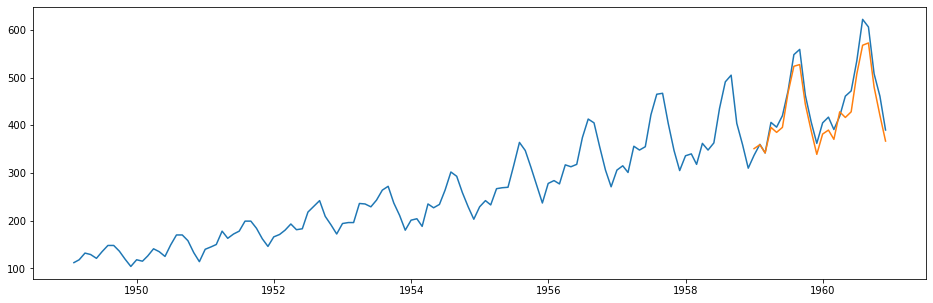

In [162]:
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions_mae_model.predicted_mean), label='arima')
plt.show();

Now with the parameters given by the AIC:

In [158]:
aic_model = sm.tsa.statespace.SARIMAX(train,
                                      order=(1, 0, 0),
                                      seasonal_order=(1, 0, 1, 12))

results = aic_model.fit()
predictions_aic_model = results.get_forecast(steps=24)

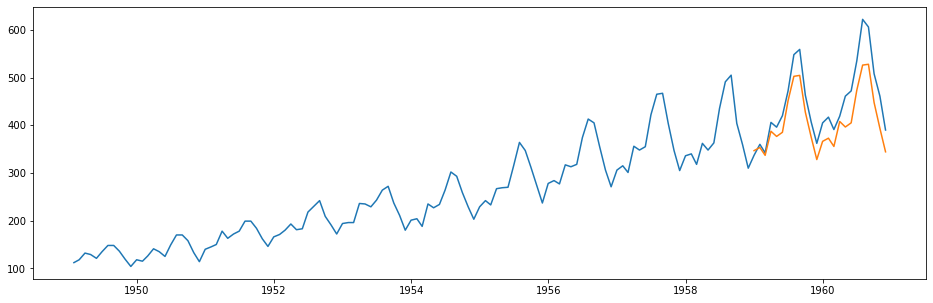

In [159]:
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions_aic_model.predicted_mean), label='arima')
plt.show();

The AIC seems considerably worse, let's quantify this!

## 4. Evaluation

Using the MAE below we corroborate our intuition, the tunning based on the MAE and validation set gave better test set results. Note that this is not guaranteed to always happen.

In [163]:
mean_absolute_error(airlines[-24:],np.exp(predictions_mae_model.predicted_mean))

23.176040744071912

In [160]:
mean_absolute_error(airlines[-24:],np.exp(predictions_aic_model.predicted_mean))

41.08515922280538

To see how good these models are we should also use a multi-step timeseries forecasting baseline. A common one is simply the trend of the time series. You may recall from the last BLU that we can use a linear regression to get it:

In [164]:
# don't worry if you don't understand this first step, it's quite simple:  
# X will just be the 0, 1, 2, 3 on the left instead of the dates
X = airlines[:-24].reset_index().index.values.reshape(-1, 1)  
X_predict = np.arange(X[-1][0],X[-1][0]+24).reshape(-1,1)

In [165]:
slr = LinearRegression(fit_intercept=True)

slr.fit(X, airlines[:-24])

predict_linear_trend = pd.Series(slr.predict(X_predict), index=airlines[-24:].index)

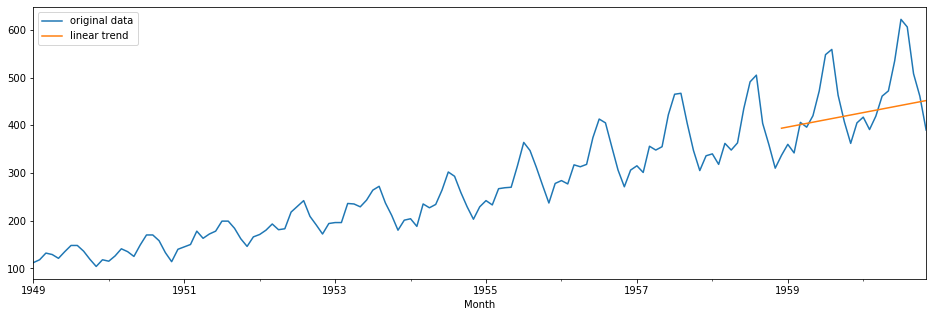

In [166]:
airlines.plot(label="original data")
predict_linear_trend.plot(label="linear trend")
plt.legend();

Let's compare the MAEs between the linear regression and the SARIMAX

In [167]:
mean_absolute_error(airlines[-24:],predict_linear_trend)

56.38087285761762

Quite an improvement!

## 4. Confidence Intervals

Also, have we told you that you can also get confidence intervals for free? Here you go!

In [168]:
def plot_predictions(series_, pred_):
    
    """ 
    Remember Sam told us to build functions as we go? Let's not write this stuff again. 
    """
    
    mean_predictions_ = np.exp(pred_.predicted_mean)

    pred_ci_ = np.exp(pred_.conf_int())
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower passengers_thousands'],
                     pred_ci_['upper passengers_thousands'], 
                     color='k', 
                     alpha=.2)

    plt.ylim([0, 700])
    plt.legend()
    plt.show()

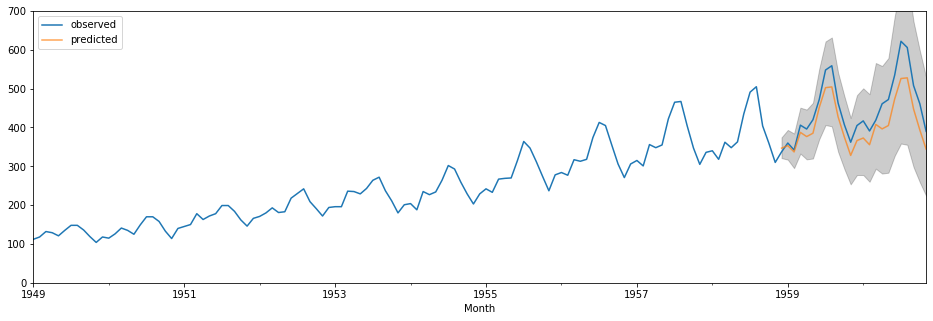

In [169]:
plot_predictions(airlines,predictions_best_model)

Confidence intervals can be very useful for business-driven decisions, in most real scenarios we're not only interested in the mean but also in the uncertainty in our predictions.

If you want to play more with classical timeseries models be sure to check the optional part 4 in this BLU which contains an excelent interactive example.